In [16]:
# import necessary libraries
import pickle
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from keras.models import Model
from keras.models import load_model
from keras.layers import Input , Dense , LSTM , Embedding , Dropout , add
from keras.utils import to_categorical, plot_model
from keras_preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from nltk.translate.bleu_score import corpus_bleu

# map to file containing captions
CAPTION_FILE = '../data/flickr8k/captions.txt'

In [17]:
# open the features file in binary mode
with open('features.pkl', 'rb') as file:
    # call load method to deserialze and store features
    features = pickle.load(file)

In [18]:
# read all captions from captions.txt and save to 'captions' string variable
with open(CAPTION_FILE, 'r') as f:
    next(f)
    captions = f.read()

# print first 10 captions in their current form
for num, line in enumerate(captions.split('\n')):
    if num < 10:
        print(line)
    else:
        break

1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .
1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with each other on the road .
1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots are staring at each other in the street .
1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each other on the road .
1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .


In [19]:
# create mapping of image to captions
mapping = {}
# process lines
for line in captions.split('\n'):
    # split the line by comma(,)
    tokens = line.split(',')
    # the length of the line should be at least 2
    if len(line) < 2:
        continue
    # save image ID and caption seperately
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption back to string
    caption = " ".join(caption)
    # create new entry for unseen id
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption to appropriate id
    mapping[image_id].append(caption)

In [6]:
# clean captions of mapping
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc.
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = '<s> ' + " ".join([word for word in caption.split() if len(word)>1]) + ' </s>'
            captions[i] = caption

In [20]:
# clean captions and print example pre and post cleaning
print('Pre Cleaning:')
for each in mapping['1000268201_693b08cb0e']:
    print(each)

clean(mapping)

print('\nPost Cleaning:')
for each in mapping['1000268201_693b08cb0e']:
    print(each)

Pre Cleaning:
A child in a pink dress is climbing up a set of stairs in an entry way .
A girl going into a wooden building .
A little girl climbing into a wooden playhouse .
A little girl climbing the stairs to her playhouse .
A little girl in a pink dress going into a wooden cabin .

Post Cleaning:
<s> child in pink dress is climbing up set of stairs in an entry way </s>
<s> girl going into wooden building </s>
<s> little girl climbing into wooden playhouse </s>
<s> little girl climbing the stairs to her playhouse </s>
<s> little girl in pink dress going into wooden cabin </s>


In [21]:
# store all captions in a list
all_captions = []

for captions in mapping.values():
    for caption in captions:
        all_captions.append(caption)

# preview the first 10 captions
all_captions[:10]

['<s> child in pink dress is climbing up set of stairs in an entry way </s>',
 '<s> girl going into wooden building </s>',
 '<s> little girl climbing into wooden playhouse </s>',
 '<s> little girl climbing the stairs to her playhouse </s>',
 '<s> little girl in pink dress going into wooden cabin </s>',
 '<s> black dog and spotted dog are fighting </s>',
 '<s> black dog and tri-colored dog playing with each other on the road </s>',
 '<s> black dog and white dog with brown spots are staring at each other in the street </s>',
 '<s> two dogs of different breeds looking at each other on the road </s>',
 '<s> two dogs on pavement moving toward each other </s>']

In [22]:
# tokenize the text
tokenizer = Tokenizer(filters='!"#$%&()*+,-.:;=?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)

# print parameters
print('Vocab Size: ', vocab_size)
print('Maximum Caption Length: ', max_length)


Vocab Size:  8485
Maximum Caption Length:  35


In [23]:
# create train test split from image IDs
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.80)
train = image_ids[:split]
test = image_ids[split:]
# create validation split from training data
val_split = int(len(train) * 0.80)
val = train[val_split:]
train = train[:val_split]


In [24]:
# create data generator to get data in batch
def batch_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq],num_classes=vocab_size)[0]
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

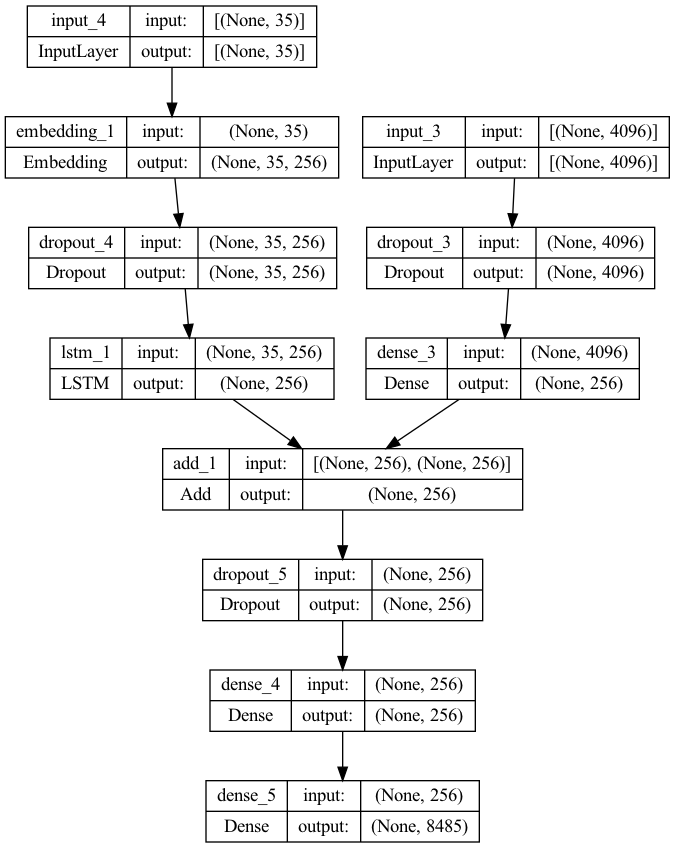

In [25]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dropout(0.5)(decoder1)
decoder3 = Dense(256, activation='relu')(decoder2)
outputs = Dense(vocab_size, activation='softmax')(decoder3)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

In [ ]:
''' 
The following is another way to define the model which is more similar to what
we are used to seeing in PyTorch. I am including it here to demonstrate the ability
subclass a model in TensorFlow. I ulitmately stuck with the more well known way of 
defining a model in TensorFlow seen above.

class CustomModel(tf.keras.Model):
    def __init__(self, vocab_size, max_length):
        super(CustomModel, self).__init__()

        # Image feature branch
        self.fe_dropout = Dropout(0.4)
        self.fe_dense = Dense(512, activation='relu')

        # Sequence feature branch
        self.se_embedding = Embedding(vocab_size, 512, mask_zero=True)
        self.se_dropout = Dropout(0.4)
        self.se_lstm = LSTM(512, activation='tanh')

        # Decoder model
        self.decoder_add = add
        self.decoder_dense1 = Dense(512, activation='relu')
        self.decoder_dense2 = Dense(vocab_size, activation='softmax')

    def call(self, inputs, training = False):
        inputs1, inputs2 = inputs

        # Image feature branch
        fe1 = self.fe_dropout(inputs1, training=training)
        fe2 = self.fe_dense(fe1)

        # Sequence feature branch
        se1 = self.se_embedding(inputs2)
        se2 = self.se_dropout(se1, training=training)
        se3 = self.se_lstm(se2)

        # Decoder model
        decoder1 = self.decoder_add([fe2, se3])
        decoder2 = self.decoder_dense1(decoder1)
        outputs = self.decoder_dense2(decoder2)

        return outputs
'''

In [13]:
# function that takes the tokenizer integer reperesentation
# of a word and returns the word itself
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [26]:
# function to generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = '<s>'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == '</s>':
            break
    return in_text

In [15]:
# train the model
epochs = 20
batch_size = 32
train_steps = len(train) // batch_size
val_steps = len(val) // batch_size
bleu_1 = 0
best_bleu = 0
best_val_loss = float('inf')

for i in range(epochs):
    # create data generators
    train_generator = batch_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    val_generator = batch_generator(val, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    print('---------------------Epoch %.0f---------------------' % (i + 1))
    model.fit(train_generator, epochs=1, steps_per_epoch=train_steps, 
              validation_data=val_generator, validation_steps=val_steps, verbose=1)
    
    # used to calculate the bleu-1 score at each epoch
    actual, predicted = list(), list()
    for key in test:
        # get actual caption
        captions = mapping[key]
        # predict the caption for image
        y_pred = predict_caption(model, features[key], tokenizer, max_length)
        # split into words
        actual_captions = [caption.split() for caption in captions]
        y_pred = y_pred.split()
        # append to the list
        actual.append(actual_captions)
        predicted.append(y_pred)
    bleu_1 = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
    print('BLEU-1: %f' % bleu_1)

    # save the model at each epoch
    # ensures we have the best model even if overfitting occurs in later epochs
    print('Saving current model...')
    model.save('rolling_model_' + str(i) + '.h5')
    print('Save complete')

---------------------Epoch 1---------------------


2023-08-06 19:55:42.154181: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


161/161 [==============================] - 150s 920ms/step - loss: 5.6468 - val_loss: 5.0426
BLEU-1: 0.467039
Saving current model...
Save complete
Saving best model...
Save complete
---------------------Epoch 2---------------------
161/161 [==============================] - 148s 917ms/step - loss: 4.6166 - val_loss: 4.3851
BLEU-1: 0.504585
Saving current model...
Save complete
Saving best model...
Save complete
---------------------Epoch 3---------------------
161/161 [==============================] - 146s 906ms/step - loss: 4.1329 - val_loss: 4.1447
BLEU-1: 0.575301
Saving current model...
Save complete
Saving best model...
Save complete
---------------------Epoch 4---------------------
161/161 [==============================] - 145s 900ms/step - loss: 3.8775 - val_loss: 4.0122
BLEU-1: 0.527212
Saving current model...
Save complete
---------------------Epoch 5---------------------
161/161 [==============================] - 148s 917ms/step - loss: 3.7047 - val_loss: 3.9364
BLEU-1: 0.

In [19]:
# validate with test data
actual, predicted = list(), list()

for key in test:
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
print("BLEU-3: %f" % corpus_bleu(actual, predicted, weights=(0.33, 0.33, 0.33, 0)))
print("BLEU-4: %f" % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

BLEU-1: 0.556309
BLEU-2: 0.324236
BLEU-3: 0.206271
BLEU-4: 0.125058


In [28]:
def generate_caption(image_name):
    # load the image
    image_id = image_name.split('.')[0]
    img_path = "../data/flickr8k/images/" + image_name
    
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

In [30]:
model = load_model('final_model.h5')

---------------------Actual---------------------
<s> black and brown furry dog is running in the grass </s>
<s> brown and black dog running through grassy field </s>
<s> large dog frolics in the grass </s>
<s> long haired black and brown dog runs through the grass </s>
<s> black dog running on green grass with mouth open </s>
--------------------Predicted--------------------
<s> black dog is running through the grass </s>


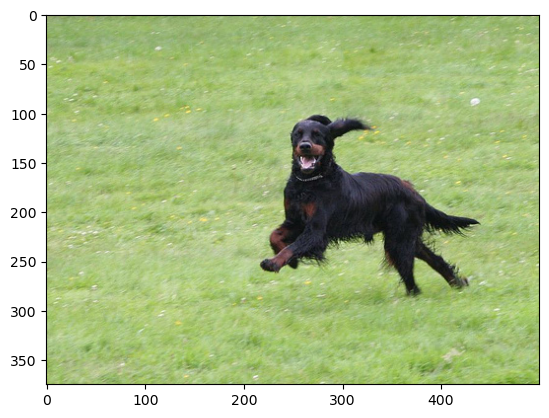

In [32]:
generate_caption("232874193_c691df882d.jpg")

---------------------Actual---------------------
<s> man is riding powered para-glider in the air at sunset </s>
<s> an individual is floating in the air with parachute </s>
<s> person in the sky connected to fan </s>
<s> parachuter in midair </s>
<s> person hang gliding at sunset </s>
--------------------Predicted--------------------
<s> parachuter in midair </s>


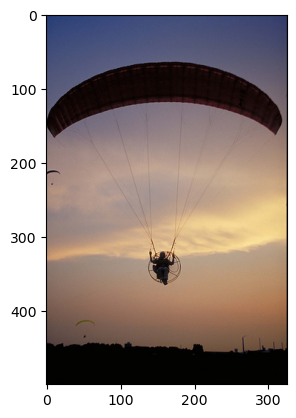

In [39]:
generate_caption("265223843_9ef21e1872.jpg")

---------------------Actual---------------------
<s> car splashes through mud and leaves on the forest floor </s>
<s> four wheel drive car is splashing through puddles on an off road trail </s>
<s> large van drives down counry road in the fall </s>
<s> large suv driving through large puddle in the forest </s>
<s> suv splashing muddy water in forest </s>
--------------------Predicted--------------------
<s> blueish vehicle driving through puddle </s>


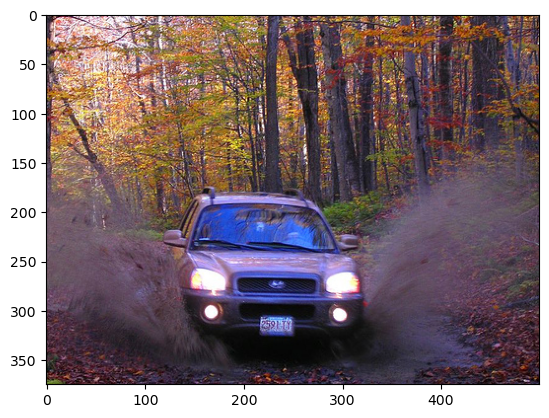

In [40]:
generate_caption("271177682_48da79ab33.jpg")

---------------------Actual---------------------
<s> "a guy playing tennis two nearby spectators and crowd watching ." </s>
<s> tennis player hitting ball </s>
<s> the tennis player gets ready to hit the ball that is almost at him </s>
<s> "the tennis player is hitting the ball with his racquet while others watch the match ." </s>
<s> the tennis player wearing white hits the tennis ball </s>
--------------------Predicted--------------------
<s> the man is playing tennis </s>


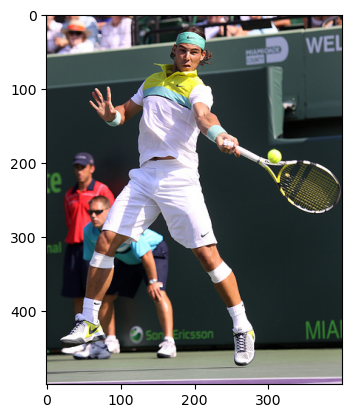

In [31]:
generate_caption("3425846980_912943b4f9.jpg")

---------------------Actual---------------------
<s> group of people playing guitars and singing </s>
<s> group of people play instruments and sing </s>
<s> girl with guitar singing with three other people </s>
<s> there is group of three women and one man singing while one of the woman plays guitar </s>
<s> three woman and man sing their hearts out in the microphone </s>
--------------------Predicted--------------------
<s> two guitarists are playing guitars onstage </s>


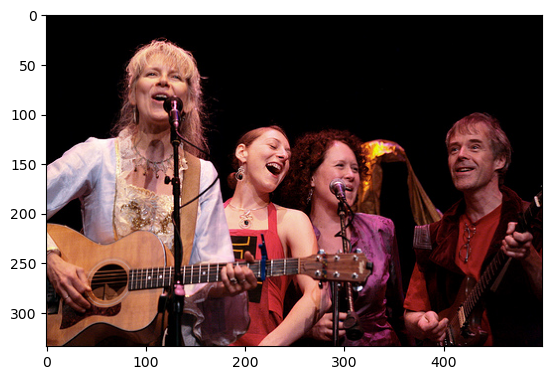

In [33]:
generate_caption("3627290893_561e176e80.jpg")

---------------------Actual---------------------
<s> man performs trick on surfboard in the water </s>
<s> surfer in yellow shirt riding wave on white surfboard </s>
<s> surfer on white surfboard wearing yellow shirt with one arm in the air </s>
<s> surfer rides the wave </s>
<s> woman in yellow shirt is surfing on white surfboard </s>
--------------------Predicted--------------------
<s> man in wetsuit is surfing on wave </s>


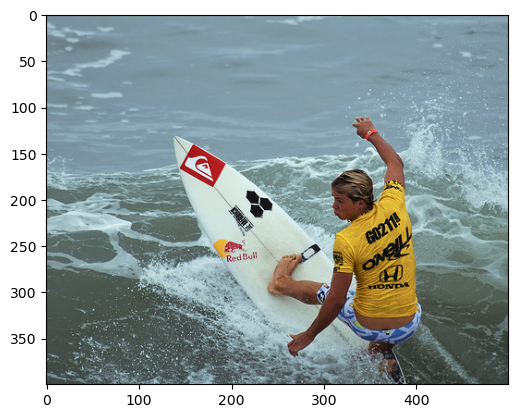

In [42]:
generate_caption("3073535022_4af81f360c.jpg")

---------------------Actual---------------------
<s> little boy and girl are jumping on trampoline in front of yellow building </s>
<s> "two children boy and girl in the air above trampoline ." </s>
<s> two children jumping on trampoline </s>
<s> two children jump on trampoline </s>
<s> two young children bounce on short trampoline </s>
--------------------Predicted--------------------
<s> man in black shirt is jumping off of rock </s>


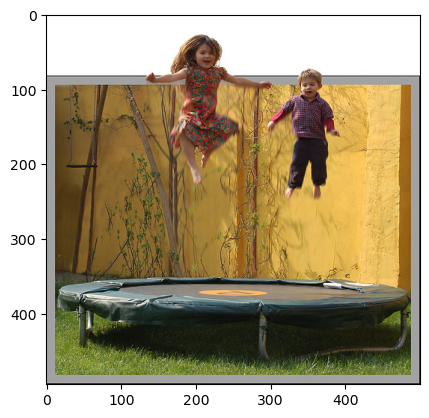

In [54]:
generate_caption("520491467_54cbc0a866.jpg")

---------------------Actual---------------------
<s> an american footballer in red is being tackled by three players in white whilst other red players look on </s>
<s> an oklahoma player is tackled playing football </s>
<s> football player being tackled by group of other players on field </s>
<s> football players are tackling football player carrying the football </s>
<s> the football player is being tackled </s>
--------------------Predicted--------------------
<s> two men play soccer </s>


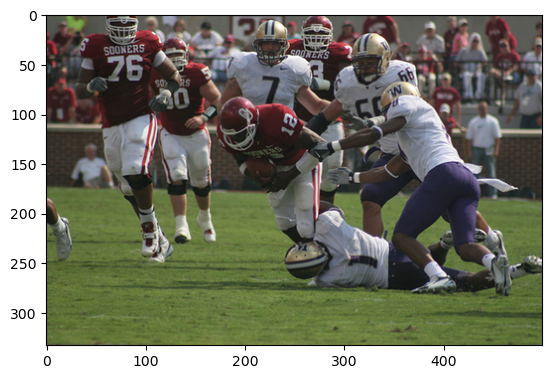

In [51]:
generate_caption("241346471_c756a8f139.jpg")

---------------------Actual---------------------
<s> girl is rowing in lake </s>
<s> girl sits on skinny canoe </s>
<s> woman sits in rowing scull and looks behind her at dock </s>
<s> woman sitting in rowboat </s>
<s> girl in thin rowboat leaving the dock of lake </s>
--------------------Predicted--------------------
<s> man in blue shirt is walking on the beach </s>


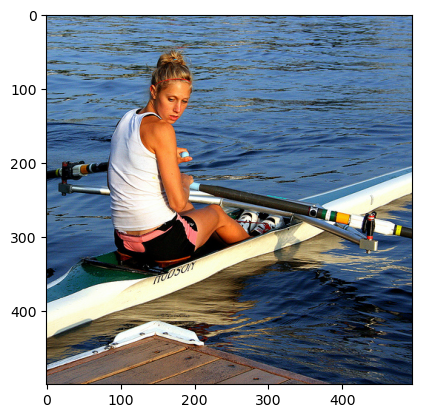

In [52]:
generate_caption("493542985_c85ad29ebe.jpg")

---------------------Actual---------------------
<s> the two dogs are white and black and are digging in the mud </s>
<s> two black and white dogs after something in the mud </s>
<s> two black and white dogs look at yellow ball in the wet sand </s>
<s> two dogs fight over ball that 's in puddle </s>
<s> two nearly identical dogs try to paw ball out of muddy water </s>
--------------------Predicted--------------------
<s> black dog is running through the snow </s>


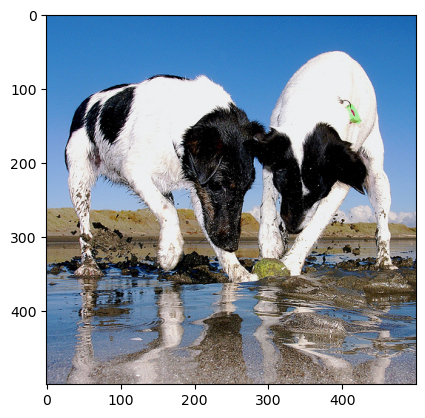

In [56]:
generate_caption("805682444_90ed9e1ef3.jpg")